This notebook performs AB test on email outcomes ONLY. "Success" in this case is whether or not an employee clicked on any one of the emails.

In [1]:
import sys
sys.path.append('..')
import os.path

import copy
from datetime import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#from typing import Optional, Tuple

## Import notebook containing the function to run the AB test, written by Kevin Wilson. 
## https://github.com/thelabdc/LAB-PythonTools/tree/master/labtools
from scripts import ab_test, perform_ab

DATA_DIR = os.path.join('..', 'data')

In [2]:
#Read in file with the correct group assignments from Notebook 1

df = pd.read_csv(os.path.join(DATA_DIR, 'outcomes_id_emails.csv'), dtype = {'EmplID': str})

#Check for dupes
print('Any duplicates?', len(df[df.duplicated(subset='EmplID')]))

Any duplicates? 0


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (22,25,28,29,30,33,34,35,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Are the number of clicks between the basic email group and the simplified choice email group different?

## Set up: Creating our outcome variable

In [3]:
# We consider "success" to be whether an employee has clicked on either of these ess links
ess1 = 'https://ess.dc.gov/psp/essprod/ESS/HRMS/c/W3EB_MENU.W3EB_SELECT_EVNT.GBL?' +\
       'Page=W3EB_SELECT_EVNT&Action=U&XFER_SOURCE_TILE=Benefits'
ess2 = 'https://ess.dc.gov/psc/essprod/ESS/HRMS/c/EF_BENEFITS_FL.W3EB_GRID_FLU.GBL'

# initialize the 'click_ess' column and setting everyone to False
df['Click_ess'] = False

# Going through all of the links as of March (supposed to be cumulative)
# There are 5 distinct links in the March set of emails (that's why arange(1,6))
for i in np.arange(1,6):
    #Click_ess = True if employee has ever clicked on either the ess1 or ess2 links
    #Because if df['Click_ess'] was ever true, true trumps false
    df['Click_ess'] = df['Click_ess'] | (df['Click0301_'+str(i)] == ess1) | (df['Click0301_'+str(i)] == ess2)


print('Number of clicks by treatment arm:')
pd.crosstab(df.treatment_real, df.Click_ess)

Number of clicks by treatment arm:


Click_ess,False,True
treatment_real,,
0.0,11256,0
1.0,10900,315
2.0,10949,266


## AB Test: Simplified Choice vs Basic

A: Simplified Choice Email
B: Basic Email
Number in control group: 11215
Number in treatment group: 11215

Total successes, control: 266
Total successes, treatment: 315

Conversion Rate:
Control Group Rate:2.3720000000000003%
Treatment Group Rate:2.809%
Percent change:18.421000000000003%

Degree of certainty: 0.98



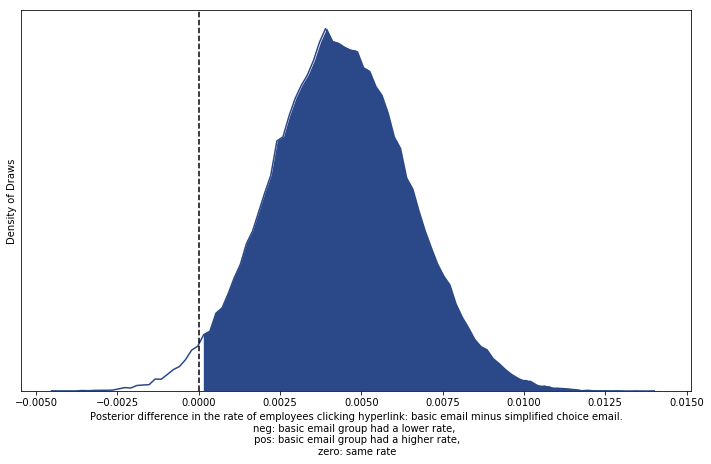

In [4]:
control, basic, simplified = perform_ab.split_groups(df)

print('A: Simplified Choice Email')
print('B: Basic Email')
'''
perform_ab_test(control_df = simplified,
                treatment_df = basic, 
                column_of_interest = 'Click_ess')'''


posterior, successes_a = perform_ab.perform_ab_test(control_df=simplified, 
                                                         treatment_df=basic, 
                                                         column_of_interest='Click_ess')

perform_ab.plot_abtest(posterior, 
                       successes_a, 
                       "clicking hyperlink", 
                       "simplified choice email", 
                       "basic email")

## AB Test: Simplified Choice vs Basic for employees already enrolled at baseline

In [5]:
enrolled_baseline = df[df['Enroll']]
not_enrolled_baseline = df[~df['Enroll']]

A: Simplified Choice Email
B: Basic Email
Number in control group: 4194
Number in treatment group: 4194

Total successes, control: 111
Total successes, treatment: 138

Conversion Rate:
Control Group Rate:2.6470000000000002%
Treatment Group Rate:3.29%
Percent change:24.324%

Degree of certainty: 0.959



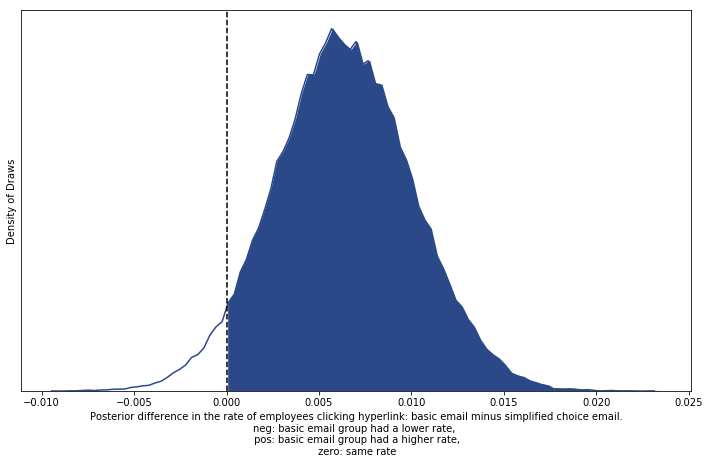

In [6]:
control, basic, simplified = perform_ab.split_groups(enrolled_baseline)

print('A: Simplified Choice Email')
print('B: Basic Email')

posterior, successes_a = perform_ab.perform_ab_test(control_df=simplified,
                                                    treatment_df=basic, 
                                                    column_of_interest='Click_ess')

perform_ab.plot_abtest(posterior, 
                       successes_a, 
                       "clicking hyperlink", 
                       "simplified choice email", 
                       "basic email")

## AB Test: Simplified Choice vs Basic for employees NOT enrolled at baseline

A: Simplified Choice Email
B: Basic Email
Number in control group: 7021
Number in treatment group: 7021

Total successes, control: 155
Total successes, treatment: 177

Conversion Rate:
Control Group Rate:2.2079999999999997%
Treatment Group Rate:2.521%
Percent change:14.194%

Degree of certainty: 0.889



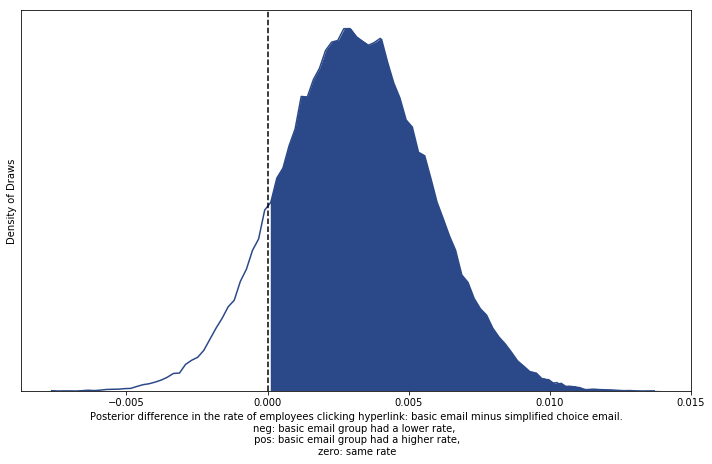

In [7]:
control, basic, simplified = perform_ab.split_groups(not_enrolled_baseline)

print('A: Simplified Choice Email')
print('B: Basic Email')


posterior, successes_a = perform_ab.perform_ab_test(control_df=simplified,
                                                    treatment_df=basic, 
                                                    column_of_interest='Click_ess')

perform_ab.plot_abtest(posterior, 
                       successes_a, 
                       "clicking hyperlink", 
                       "simplified choice email", 
                       "basic email")

## Exploratory: Looking at email opens by agency

#### Clean

In [8]:
#VM: So this cell is essentially cleaning the "Agency Name" column. 
#Basically, there are 92 unique Agency Codes, but 140 unique Agency Names. 
#For example, 'Administrative Hearings, Ofc' and 'Office ofAdministrative Hearin' have the same Agency Code
#We want to map it so that 'Administrative Hearings, Ofc' = 'Office ofAdministrative Hearin', so same name for same unique code

#Create a dictionary, so that every agency name is linked to its agency code
# See https://stackoverflow.com/questions/51570364/underscore-in-for-loop for why the underscore is needed
one = {row['Agency Name']: row['Agency Code'] for _, row in df.iterrows()}

#create a dict, so that the agency code becomes the key, and agency name becomes the value
#This drops the extra agency name so that one agency name is mapped to one agency code
code_to_name = {v: k for k, v in one.items()}

#Map the names
name_to_name = {k: code_to_name[v] for k, v in one.items()}

#Create a column in the df that maps the names in "Agency Name" to the names in name_to_names
df['agency_name'] = df['Agency Name'].map(name_to_name)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 <a list of 60 Text xticklabel objects>)

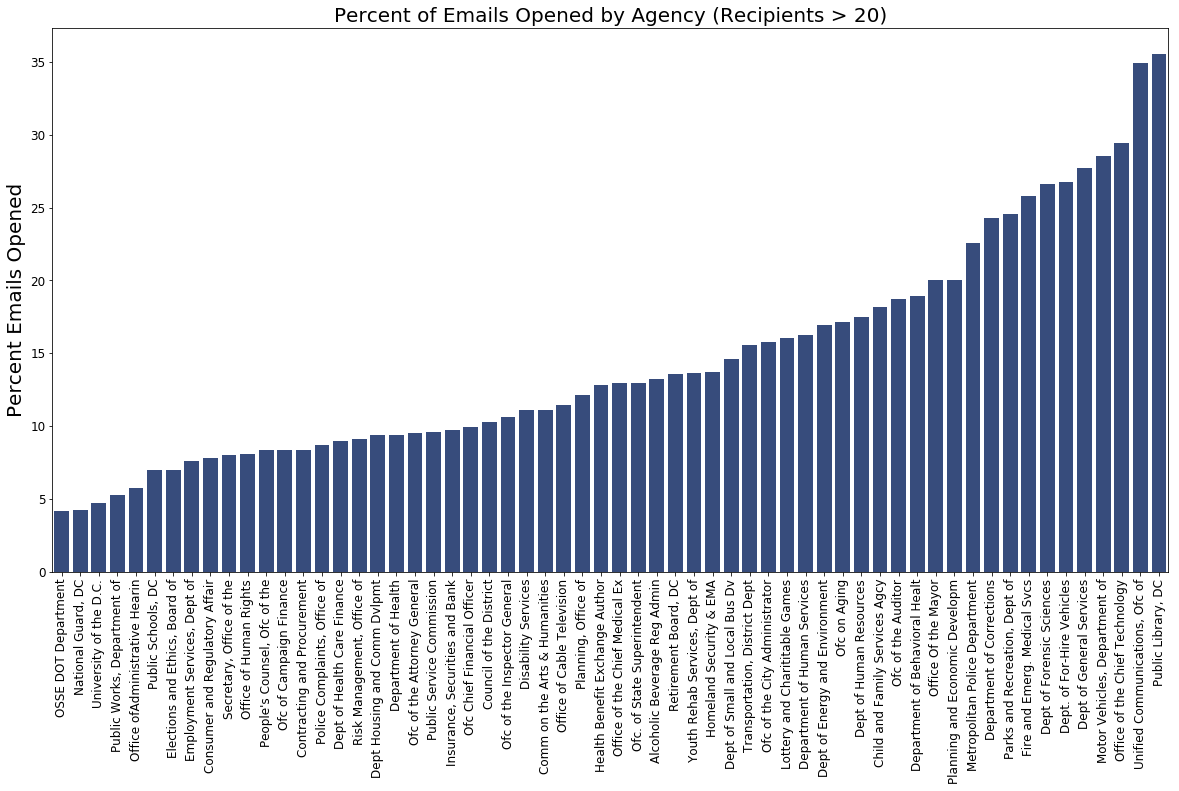

In [9]:
#An employee opened the email if their cumulative opens through March are greater than -
df['Opened'] = df.Opens0301 > 0

# Calculate the number of employees in each agency
n = df['agency_name'].value_counts().sort_index()

# Percent of employees who opened their emails
z = 100 * df.groupby('agency_name')['Opened'].mean().sort_index()

# Filter data for the agencies that have appeared more than 20 times, % of opens by agency
x = z[n > 20].sort_values()

fig, ax = plt.subplots(figsize = (20, 10))
sns.barplot(x.index, x.values, color = '#2b4888', ax = ax)
ax.set_title('Percent of Emails Opened by Agency (Recipients > 20)', fontsize = 20)
ax.set_xlabel('')
ax.set_ylabel('Percent Emails Opened', fontsize = 20)
plt.tick_params(which = 'major', labelsize = 12)
plt.xticks(rotation = 90)